In [1]:
import numpy as np
import math
import pandas as pd
import random
import warnings
import matplotlib.pyplot as plt
from tqdm import tqdm
from math import pi
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesScalerMinMax, TimeSeriesResampler
from statsmodels.tsa.stattools import adfuller 
from sklearn.metrics import accuracy_score, classification_report

from tslearn.shapelets import ShapeletModel
from tslearn.shapelets import grabocka_params_to_shapelet_size_dict
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


**Calcolo score (definito come numero di incidenti data la settimana e la città) e aggiungo la colonna della variabile isKilled**.\
Creo due tabelle pivot: df_incident_count indica gli incidenti per Y-M-W e per città, df_killed invece se c'è stata almeno una vittima;\
vengono prese in considerazione solo le città che presentano un numero di settimane con incidenti che supera il 15% del totale delle settimane nell’arco dei 4 anni.


In [2]:
df = pd.read_csv("data/time_Series_Data.csv")
df['date'] = pd.to_datetime(df['date'])
df['year_month_week'] = df['date'].dt.to_period('W').dt.strftime('%Y-%m-%W')

weekly_data_incident_count = df.groupby(['year_month_week', 'city']).size().reset_index(name='incident_count')
weekly_data_incident_count.dropna(inplace=True)

selected_city = weekly_data_incident_count.groupby(['city']).count()
selected_city = selected_city[selected_city.year_month_week >= 32].reset_index()['city']
df_incident_count = weekly_data_incident_count[weekly_data_incident_count.city.isin(selected_city)]

df_incident_count = df_incident_count.pivot(index="city", columns="year_month_week", values="incident_count")
df_incident_count.fillna(0, inplace=True)

In [3]:
weekly_data_tot_killed = df.groupby(['year_month_week', 'city'])['n_killed'].sum().reset_index(name='tot_killed')
weekly_data_tot_killed.dropna(inplace=True)

df_killed = weekly_data_tot_killed[weekly_data_tot_killed.city.isin(selected_city)]

df_killed = df_killed.pivot(index="city", columns="year_month_week", values="tot_killed")
df_killed.fillna(0, inplace=True)
df_killed = df_killed > 0


weekly_data_tot_killed['isKilled'] = weekly_data_tot_killed['tot_killed'] > 0 
weekly_data_tot_killed.head()

,year_month_week,city,tot_killed,isKilled
0,2014-01-00,Albany,0.0,False
1,2014-01-00,Albuquerque,0.0,False
2,2014-01-00,Allentown,0.0,False
3,2014-01-00,Altoona,0.0,False
4,2014-01-00,Amarillo,0.0,False


In [4]:
df_killed.head()

year_month_week,2014-01-00,2014-01-01,2014-01-02,2014-01-03,2014-02-04,2014-02-05,2014-02-06,2014-02-07,2014-03-08,2014-03-09,...,2017-10-43,2017-11-44,2017-11-45,2017-11-46,2017-11-47,2017-12-48,2017-12-49,2017-12-50,2017-12-51,2017-12-52
city,,,,,,,,,,,,,,,,,,,,,
Aberdeen,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
Abilene,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Aiken,False,False,False,False,False,False,False,False,False,True,...,False,False,False,True,False,False,False,False,False,False
Akron,False,False,False,True,False,False,False,False,False,False,...,False,False,False,True,False,False,True,True,False,True
Albany,False,False,False,False,False,False,True,False,False,False,...,True,False,False,False,False,False,True,False,False,False


In [5]:
df_incident_count.head()

year_month_week,2014-01-00,2014-01-01,2014-01-02,2014-01-03,2014-02-04,2014-02-05,2014-02-06,2014-02-07,2014-03-08,2014-03-09,...,2017-10-43,2017-11-44,2017-11-45,2017-11-46,2017-11-47,2017-12-48,2017-12-49,2017-12-50,2017-12-51,2017-12-52
city,,,,,,,,,,,,,,,,,,,,,
Aberdeen,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
Abilene,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
Aiken,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,2.0,0.0,1.0,0.0,1.0,2.0,0.0,2.0,1.0
Akron,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,4.0,1.0,1.0,4.0,2.0,2.0,3.0
Albany,1.0,0.0,5.0,0.0,2.0,0.0,2.0,1.0,1.0,0.0,...,4.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0


Esamino i valori più alti della tabella pivot df_incident_count

In [6]:
print(np.sort(df_incident_count.values.flatten())[::-1])

[90. 90. 89. ...  0.  0.  0.]


### Shapelet Discovery

In [7]:
timeseries_data = df_incident_count.values
len(timeseries_data)

571

In [8]:
labels = df_killed.values
len(labels) #una per città

571

**Considero la media dei valori come valore effettivo per quella posizione**

In [9]:
new_labels = []
for i in labels:
    sum = 0
    for j in i:
        sum = sum+j
    mean = sum / len(i)
    new_val = round(mean,0)
    new_labels.append(new_val)

labels = new_labels

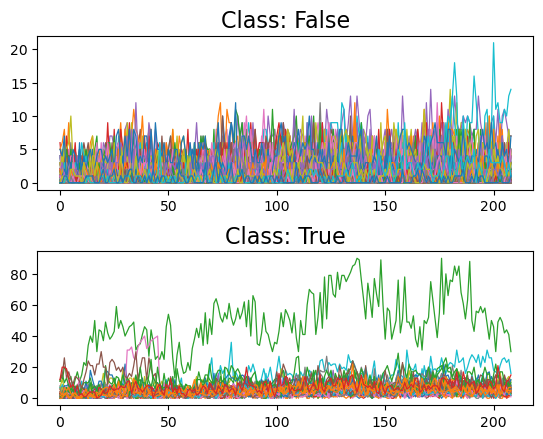

In [10]:
plt.figure()
for iClasse, classe in enumerate(['False', 'True']):
    plt.subplot(2, 1, iClasse + 1)
    
    # Iterate through the array using two for-loops
    for i in range(len(timeseries_data)):
        a = []
        for j in range(len(timeseries_data[i])):
            incident_count = timeseries_data[i][j]
            isKilled = labels[i]
            
            if(iClasse == 0 and not isKilled): 
                a.append(incident_count)
            elif(iClasse == 1 and isKilled):
                a.append(incident_count)
        
        plt.plot(a, color='C'+str(i%100), linewidth=0.9)

        plt.title('Class: {}'.format(classe), fontsize=16)

plt.subplots_adjust(hspace=0.4)
plt.show()

In [11]:
n_ts, ts_sz = timeseries_data.shape
n_classes = len(set(labels))

shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
                                                       ts_sz=ts_sz,
                                                       n_classes=n_classes,
                                                       l=0.1,
                                                       r=1)

print('n_ts', n_ts)
print('ts_sz', ts_sz)
print('n_classes', n_classes)
print('shapelet_sizes', shapelet_sizes)

n_ts 571
ts_sz 209
n_classes 2
shapelet_sizes {20: 5}


In [12]:
shp_clf = ShapeletModel(n_shapelets_per_size=shapelet_sizes,
                        optimizer="sgd",
                        weight_regularizer=.01,
                        max_iter=200,
                        verbose=1)

C:\Users\Alessia\anaconda3\Lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


In [13]:
shp_clf.fit(timeseries_data, labels)



Epoch 1/200


3/3 [==============================] - 2s 20ms/step - loss: 2649.0151 - binary_accuracy: 0.5639 - binary_crossentropy: 2644.9236
Epoch 2/200
3/3 [==============================] - 0s 16ms/step - loss: 4053.9480 - binary_accuracy: 0.9247 - binary_crossentropy: 4048.3271
Epoch 3/200
3/3 [==============================] - 0s 16ms/step - loss: 3208.9412 - binary_accuracy: 0.9247 - binary_crossentropy: 3205.3245
Epoch 4/200
3/3 [==============================] - 0s 16ms/step - loss: 2369.2998 - binary_accuracy: 0.9264 - binary_crossentropy: 2367.3074
Epoch 5/200
3/3 [==============================] - 0s 16ms/step - loss: 1613.5927 - binary_accuracy: 0.9264 - binary_crossentropy: 1612.6407
Epoch 6/200
3/3 [==============================] - 0s 12ms/step - loss: 763.7737 - binary_accuracy: 0.9264 - binary_crossentropy: 763.5416
Epoch 7/200
3/3 [==============================] - 0s 16ms/step - loss: 2566.0591 - binary_accuracy: 0.5254 - binary_crossentropy: 2565.2861
Epoch 8/200

LearningShapelets(max_iter=200, n_shapelets_per_size={20: 5}, verbose=1,
                  weight_regularizer=0.01)

In [14]:
predicted_labels = shp_clf.predict(timeseries_data)
print("Correct classification rate:", accuracy_score(labels, predicted_labels))
predicted_locations = shp_clf.locate(timeseries_data)

3/3 [==============================] - 0s 8ms/step
Correct classification rate: 0.07355516637478109
3/3 [==============================] - 0s 5ms/step


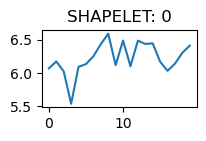

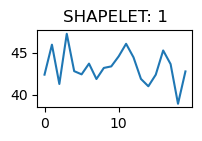

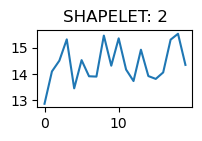

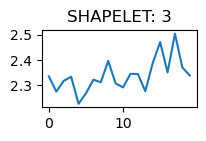

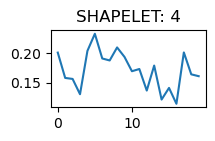

In [15]:
len(shp_clf.shapelets_as_time_series_)
for i, shp in enumerate(shp_clf.shapelets_as_time_series_):
    plt.figure(figsize=(2,1))
    plt.title(f"SHAPELET: {i}")
    plt.plot(shp)
    plt.show()